# Clustering

In this notebook we review a few clustering techniques. You'll then be asked to implement these techniques on your own in Notebook 2.

## What You'll Accomplish

You'll:
<ul>
    <li>Learn the $k$-means clustering algorithm with synthetic data,</li>
    <li>See how hierarchical clustering produces clusters with dendrograms,</li>
    <li>Implement density based clustering with DBScan,</li>
    <li>Compare how all of our algorithms perform on the MNIST data set.</li>
</ul>

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

Let's look at this dataset.

In [2]:
np.random.seed(614)
X = np.concatenate([[-2,-2] + 1.7*np.random.randn(100,2),
                   [2,2] + 1.7*np.random.randn(100,2)])

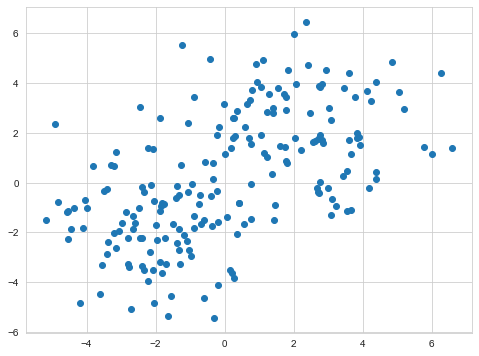

In [3]:
plt.figure(figsize=(8,6))

plt.scatter(X[:,0],X[:,1])

plt.show()

Now we may (correctly) suspect that groups exist in this data set, but since our dataset is unlabeled we don't know who belongs to which group.

This is what clustering looks to solve.

## $k$-Means Clustering

Because of the naming convention it is easy to get this technique confused with $k$-Nearest Neighbors. The only real relationship between the two is that they can both be labeled as machine learning techniques.

In $k$-means clustering you start by setting a number, $k$, of clusters that you'd like to detect. 

The algorithm then starts by randomly assigned each data point to a group like so:

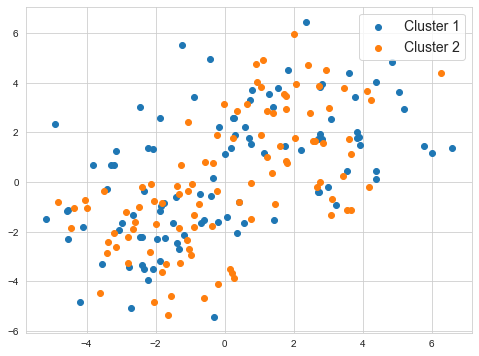

In [4]:
plt.figure(figsize=(8,6))

sample = np.random.choice(range(0,200),100,replace=False)
not_sample = [i for i in range(0,200) if i not in sample]


plt.scatter(X[not_sample,0],X[not_sample,1], label="Cluster 1")
plt.scatter(X[sample,0],X[sample,1], label="Cluster 2")

plt.legend(fontsize=14)

plt.show()

After the random initial assignment the algorithm then computes each cluster's centroid and calculates the sum of the Euclidean distance, called the <i>inertia</i>, between all of the nodes and their cluster's centroid. It then goes through each node and checks if changing that node's cluster would lower the inertia, if it would it switches it over to a different cluster. After going through each node it starts the process over again, calculating the potentially new centroids and inertia.

This process is continued until either:
<ol>
    <li>a maxinum number of iterations is reached (sklearn's default is $300$ controlled by 'max_iter'), or</li>
    <li>the change in inertia falls below a tolerance level at which point you're happy with the result (sklearn's default is $0.0001$ controlled by 'tol').</li>
</ol>

Again this is another instance of a random greedy algorithm, so a single run through may not produce the "optimal split", meaning lowest overall inertia, so what is typically done is you run $k$-means clustering multiple times and keep the one with lowest inertia. `sklearn` does this a default of $10$ times and is controlled by `n_init`, as a side note this process of running a random greedy algorithm multiple times is quite common.

Let's see how to implement it with `sklearn`

In [5]:
# the function is stored in sklearn.cluster
from sklearn.cluster import KMeans

In [6]:
# Let's try just 2 clusters
kmeans = KMeans(2)

In [7]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [8]:
clusters = kmeans.predict(X)

clusters[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0], dtype=int32)

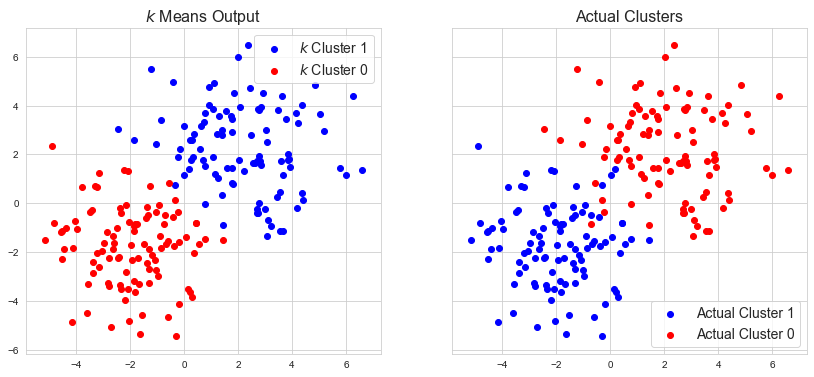

In [9]:
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True,sharey=True)


ax[0].scatter(X[clusters==1,0],X[clusters==1,1], label="$k$ Cluster 1",c="b")
ax[0].scatter(X[clusters==0,0],X[clusters==0,1], label="$k$ Cluster 0",c="r")

ax[0].legend(fontsize=14)
ax[0].set_title("$k$ Means Output",fontsize=16)

ax[1].scatter(X[:100,0],X[:100,1], label="Actual Cluster 1",c="b")
ax[1].scatter(X[100:,0],X[100:,1], label="Actual Cluster 0",c="r")

ax[1].legend(fontsize=14)
ax[1].set_title("Actual Clusters",fontsize=16)

plt.show()

As I'm sure someone has asked by now, how do I choose $k$?!

Let's see what would have happened if we used $k=5$ instead.

In [10]:
# Let's try 5 clusters
kmeans = KMeans(5)

In [11]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
clusters = kmeans.predict(X)

clusters[:10]

array([2, 1, 1, 3, 1, 3, 3, 1, 2, 2], dtype=int32)

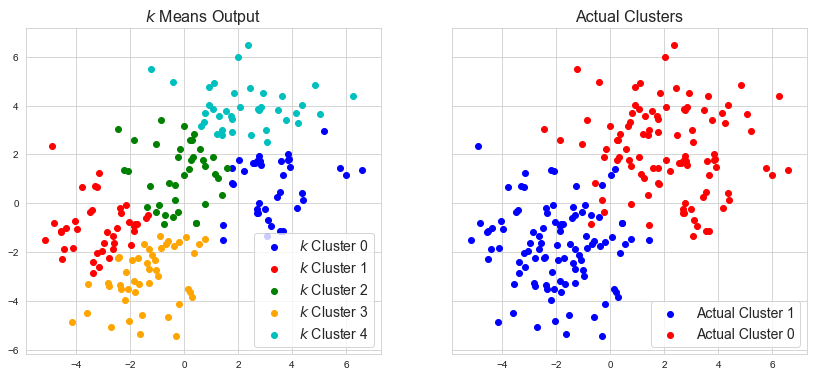

In [13]:
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True,sharey=True)

cs = ["b","r","g","orange","c"]

for i in range(5):
    ax[0].scatter(X[clusters==i,0],X[clusters==i,1], label="$k$ Cluster " + str(i),c=cs[i])

ax[0].legend(fontsize=14)
ax[0].set_title("$k$ Means Output",fontsize=16)

ax[1].scatter(X[:100,0],X[:100,1], label="Actual Cluster 1",c="b")
ax[1].scatter(X[100:,0],X[100:,1], label="Actual Cluster 0",c="r")

ax[1].legend(fontsize=14)
ax[1].set_title("Actual Clusters",fontsize=16)

plt.show()

When compared to the actual clustering we can see how our output wasn't great, but if we didn't know the true labels I argue that our $k$ means output doesn't seem unreasonable.

As we can see this is a tricky question, and choosing the "wrong" $k$ may make your output useless. To my knowledge there is no algorithmic way to guarantee you've chosen the correct number of clusters. You may be tempted to choose the one with lowest inertia, but you can arbitrarily get an inertia of $0$ by letting $k$ be the number of observations in the data set, and more generally the inertia of the output tends to decrease as you increase $k$. This makes it a non-ideal measure for clustering performance.

There is one technique that looks at how the how much variation in the data the clusters have captured. If you're interested this is explored in the Unsupervised Learning HW.

In your projects you'll have to use your best judgement on what the correct number of $k$. Finding a way to validate the clusters you've produced is a big problem with this technique.

Here is the $k$ means documentation if you'd like to learn more, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html</a>.

### Preprocessing Data

As with any algorithm that relies on distance be sure to put your data through a scaler before performing $k$ means clustering. A good default is `StandardScaler`.

## Practice

Run the following line of code. This will download a subset of the real mnist data, note that it may take a little bit to load into your computer. I've included an alternative in case your laptop is not capable of loading the data.

Run the mnist data through $k$ means clustering then devise a way using `pandas` or `numpy` to see how well it performed at detecting the different numbers and sorting them into the correct groups. 

In [14]:
# try this first
X = pd.read_csv("https://raw.githubusercontent.com/cerndb/dist-keras/master/examples/data/mnist.csv")

X.head()

# if that doesn't work comment it out then uncomment this
# from sklearn.datasets import load_digits
# X, y = load_digits(n_class=10, return_X_y=True)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y = X['label']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], y, test_size=.3, random_state=42)

In [17]:
kmeans_machine = KMeans(n_clusters=10)


In [18]:
kmeans_machine.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
print(X_train.shape, X_test.shape)

(29400, 784) (12600, 784)


In [26]:
y_pred = kmeans_machine.predict(X_test)

In [43]:
y_train_pred = kmeans_machine.predict(X_train)

In [48]:
y_train_out = np.concatenate([y_train_pred.reshape(-1,1), y_train.to_numpy().reshape(-1,1)], axis=1)

In [50]:
y_train_out = pd.DataFrame(data=y_train_out, columns=['actual','pred'])

In [62]:
y_train_out.groupby('actual').agg(lambda x: x.value_counts().index[0])

,pred
actual,
0,4
1,1
2,1
3,0
4,3
5,0
6,8
7,7
8,6




### $k$ Means Clustering in Soccer

A former Invitations to Industry speaker, Eliot McKinley <a href="https://twitter.com/etmckinley">@etmckinley</a> on Twitter, uses these sorts of techniques in both his research work at Vanderbilt and his writing on Soccer Analysis. Here's a post where he used $k$-means clustering to analyze soccer passing style <a href="https://www.americansocceranalysis.com/home/2019/3/11/using-k-means-to-learn-what-soccer-passing-tells-us-about-playing-styles">https://www.americansocceranalysis.com/home/2019/3/11/using-k-means-to-learn-what-soccer-passing-tells-us-about-playing-styles</a>. 

If you find that interesting I encourage you to follow Eliot on Twitter and support his writing. He does some great work, hopefully someday he can come work for the Columbus Crew!

$k$ Means clustering is quite popular in sports data analysis, and in the real world in general.


## Hierarchical Clustering

We now introduce a second clustering technique, <i>hierarchical clustering</i>.

One big difference between this and $k$ means is that you don't need to set the number of clusters you'd like to detect ahead of time. 

The approach with hierarchical clustering is to build what is known as a <i>dendrogram</i>. I'll explain the concept with words, if you find this explanation difficult to read just scroll down to the image below.

In hierarchical clustering you start by assigning each data point to its own cluster. You then slowly start to combine them together into larger clusters by finding clusters that are "close" to one another. Here close depends on the measure you are using, some popular ones are to take the minimum distance between all points in the two clusters being considered (implemented with method `single` below), or to take the distance between the centroid of the two clusters (implemented with `centroid` below) in all cases the typical distance metric is the Euclidean distance.

The dendrogram is a way to illustrate this process, you start by placing each of the data points along the $x$-axis. Then as you increase the distance measure between clusters you draw lines straight up. Once the distance measure is large enough and clusters merge into a larger cluster the straight lines are connected into a new straight line. This continues until the distance threshold is increased enough so that all of the data points are considered part of the same large cluster.

Let's look at how this is done with a $5$ point data set.

In [63]:
# This is where the functions are stored
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [64]:
np.random.seed(440)
X = np.random.random((5,2))

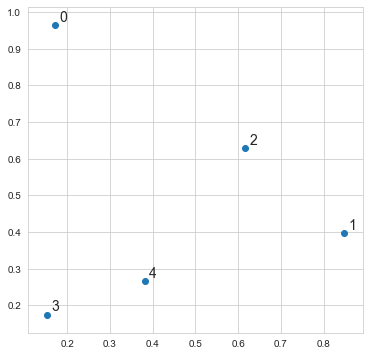

In [65]:
plt.figure(figsize=(6,6))

plt.scatter(X[:,0],X[:,1])


for i in range(0,5):
    plt.text(X[i,0] + .01,X[i,1]+.01,str(i),fontsize=14)
    
    
plt.show()

In [66]:
# You input the data
# then tell the method how you want measure
# closeness
# here I've chose 'centroid'
Z = linkage(X, 'centroid')

# Z returns an array it is called a linkage vector
# I'll use a dataframe to examine it
# it returns four columns
# that I'll describe below
pd.DataFrame(Z,columns = ['cluster_1','cluster_2','distance','new_cluster_size'])

,cluster_1,cluster_2,distance,new_cluster_size
0,3.0,4.0,0.246761,2.0
1,1.0,2.0,0.326850,2.0
2,5.0,6.0,0.548826,4.0
3,0.0,7.0,0.681749,5.0


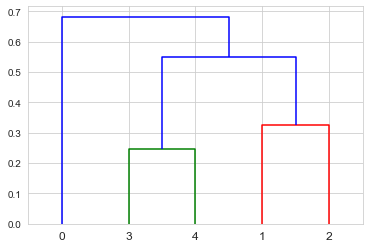

In [25]:
# I can plot the dendrogram like so
# I input a linkage vector
dendrogram(Z)

plt.show()

Let's cross reference this with the above plot of the $5$ points in $\mathbb{R}^2$.


### So How Do I Get Clusters?

In order get an actual cluster assigned to each data point you have to choose a distance and then make a horizontal cutpoint in the dendrogram. For instance in the example above if I make a cut with the distance equal to $0.1$ each data point is in its own cluster. As another example if I take the distance to be $0.4$, then $0$ will be in a cluster on its own, $3$ and $4$ will be in a cluster, and $1$ and $2$ will be in their own cluster. As a final example if I take the distance to be $0.6$ then $0$ is still in a cluster on its own, but now $1$ $2$ $3$ and $4$ are all in a single cluster.

Let's see how to implement this in python.

In [67]:
# We now use fcluster
# Input the linkage vector
# My distance cutpoint is .4
# We set R = None and
# monocrit = None
# since we only want the list of clusters returned
fcluster(Z, t=.4, criterion='distance')

array([3, 2, 2, 1, 1], dtype=int32)

Here are links to the documentation of all the functions we used to produce these clusters.
<ol>
    <li>linkage, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html">https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html</a>,</li>
    <li>dendrogram, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram">https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram</a>,</li>
    <li>fcluster, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html">https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html</a>.</li>
</ol>

### Which is Better?

So now we have two approaches to clustering and I'm sure some of you are asking is this better than $k$ means?

There's no way to know ahead of time which one will produce better results. I will say that one thing I like about the hierarchical approach is that you don't have to decide on the number of clusters before fitting the algorithm. The hierarchical approach does also convey a bit more information than $k$ means because of the dendrogram.

However for large data sets $k$-means can be quicker computationally.

If you're interested in learning more about the differences between the two check out this presentation comparing the two <a href="http://santini.se/teaching/ml/2016/Lect_10/10c_UnsupervisedMethods.pdf">http://santini.se/teaching/ml/2016/Lect_10/10c_UnsupervisedMethods.pdf</a>.

## Questions?

Go ahead and ask some questions then we'll do some more practice.

## Practice

Return to the synthetic data from $k$-means compare the output from $k$-means with 2 clusters and the hierarchical clustering results. Compare the results, does one perform better than the other?

If you have the time during the breakout session also return to the mnist data and see if the hierarchical clustering algorithm is better at correctly sorting the digits.

In [68]:
# A return to the synthetic data
np.random.seed(614)
X = np.concatenate([[-2,-2] + 1.7*np.random.randn(100,2),
                   [2,2] + 1.7*np.random.randn(100,2)])

In [69]:
# Code Here
Z = linkage(X, 'centroid')
pd.DataFrame(Z,columns = ['cluster_1','cluster_2','distance','new_cluster_size'])

,cluster_1,cluster_2,distance,new_cluster_size
0,10.0,42.0,0.003717,2.0
1,70.0,79.0,0.027516,2.0
2,127.0,158.0,0.032282,2.0
3,103.0,173.0,0.042807,2.0
4,35.0,87.0,0.048043,2.0
...,...,...,...,...
194,11.0,387.0,3.827334,7.0
195,332.0,393.0,3.955753,96.0
196,315.0,395.0,4.363493,98.0
197,394.0,396.0,4.414325,105.0


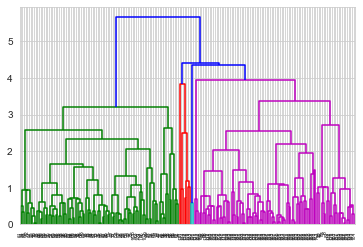

In [72]:
# Code Here

dendrogram(Z)

plt.show()





In [76]:
# Code Here

cluster = fcluster(Z, t=4, criterion='maxclust')


In [77]:
X = np.concatenate([X, cluster], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [75]:
# Code Here

cs = ["b","r","g","orange","c"]

for i in range(5):
    plt.scatter(X[clusters==i,0],X[clusters==i,1], label="$k$ Cluster " + str(i),c=cs[i])




array([[-1.37760193e+00, -1.56698808e-01],
       [-3.21915187e+00,  6.73856272e-01],
       [-4.03881646e+00, -7.22513926e-01],
       [ 7.62227668e-01, -1.48240960e+00],
       [-2.04699277e+00, -7.53062263e-01],
       [-1.81885834e+00, -3.63289732e+00],
       [ 5.50615803e-01, -1.64803519e+00],
       [-2.14252800e+00, -9.08067576e-02],
       [-4.03271491e-01, -5.57940910e-01],
       [-2.21583254e+00,  1.38178524e+00],
       [ 4.22061630e-01, -8.22503798e-01],
       [-4.90885672e+00,  2.34099242e+00],
       [-1.06229943e+00, -3.71928477e-01],
       [-3.15804455e+00, -2.61319019e+00],
       [-4.44294276e+00, -1.86288383e+00],
       [-9.01356937e-01, -1.34788026e+00],
       [-1.30160646e+00, -3.27746198e+00],
       [-3.99089502e+00, -1.04000930e+00],
       [-3.39590487e+00, -2.87088977e+00],
       [ 3.58729508e-01, -2.05414051e+00],
       [-4.37289769e+00, -1.02803084e+00],
       [-1.17746288e+00, -2.11793760e+00],
       [-9.46940196e-01, -7.34459799e-02],
       [-1.

In [ ]:
# Code Here








## Density-Based Spatial Clustering of Application with Noise (DBSCAN)

This technique focuses on the density of the points in the feature space. 

The main concept behind DBSCAN is that dense regions of data are the result of clusters, and that sparse regions of data are the result of noise.

Before giving an overview of the algorithm we'll need to introduce a bit of jargon. 

The <i>density</i> at a single observation $i$ is the number of points within a circle of radius `eps` (stands for epsilon).

A a circle of radius `eps` is considered <i>dense</i> if it contains `min_samples` points. 

We say a point is a <i>core point</i> if there are at least `min_samples` points within an open circle of radius `eps` centered at the point. A point is a <i>border point</i> if it has fewer than `min_samples` points within `eps` of it, but it is contained in a core point's `eps` open neighborhood. <i>Noise points</i> are those data points that are neither core nor border points.

The DBSCAN algorithm goes through and labels each point as a core point, border point, or noise. Noise is thrown out and, in `sklearn`, labeled as $-1$. It then joins core points that are within each other's neighborhoods, these collections of core points are the foundations of our clusters. Finally border points are assigned to the cluster to which they are closest.

Let's demonstrate the process.

In [78]:
from sklearn.cluster import DBSCAN

In [79]:
x = np.array([1.1, 1, .9, .7, 1.75, 
             2.2, 2.3, 2.35, 2.4])

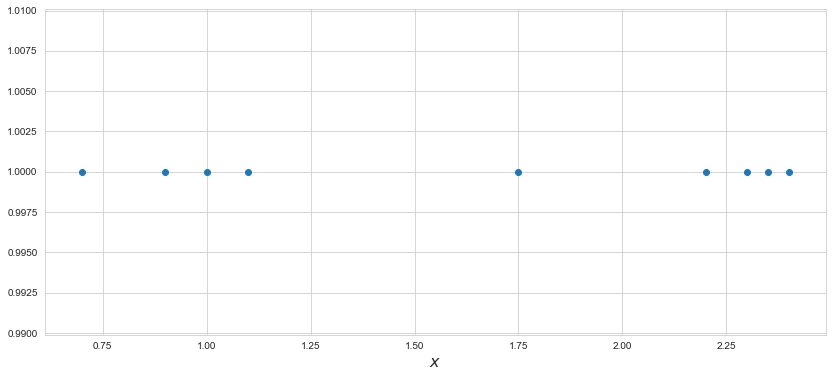

In [80]:
plt.figure(figsize=(14,6))

plt.scatter(x,np.ones(len(x)))

plt.xlabel("$x$",fontsize=16)

plt.show()

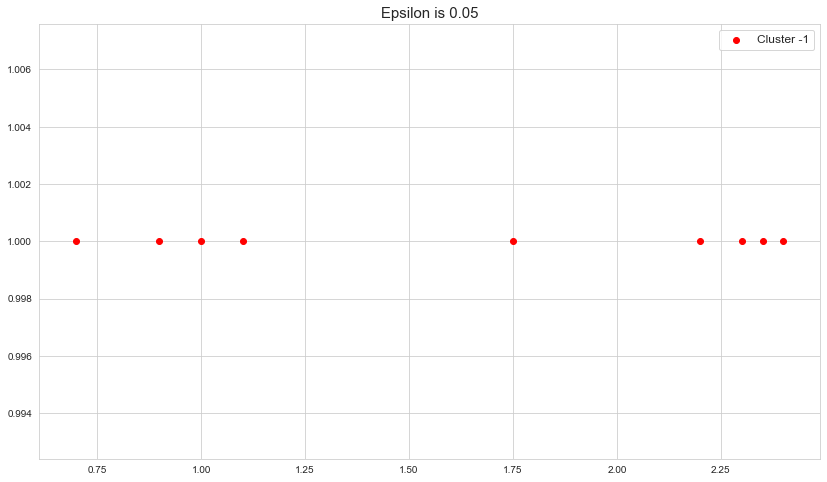

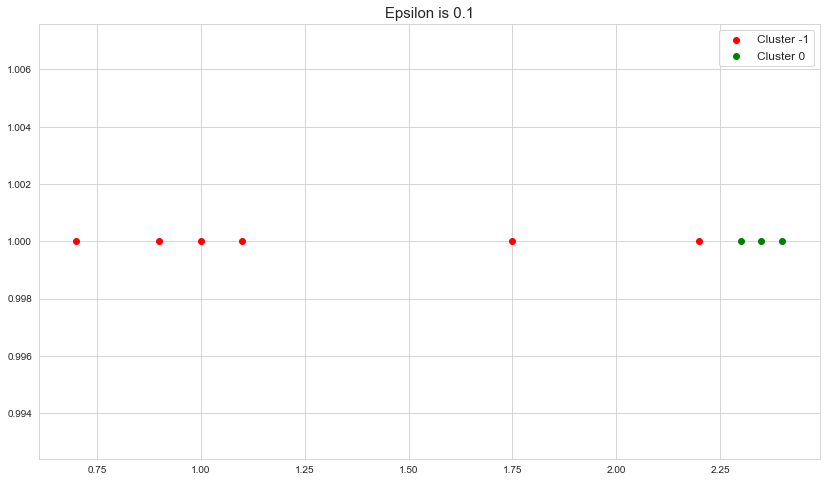

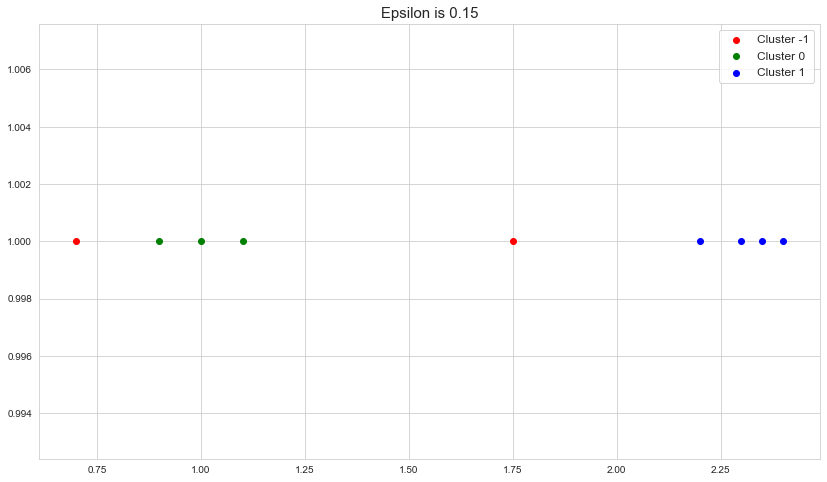

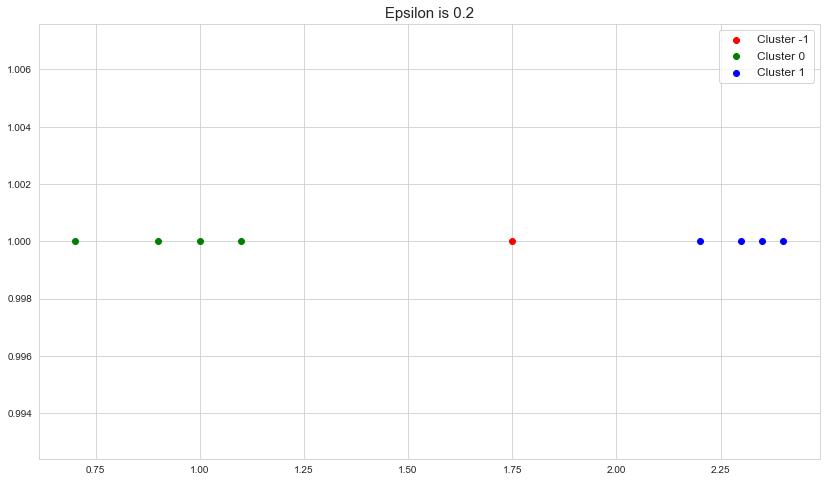

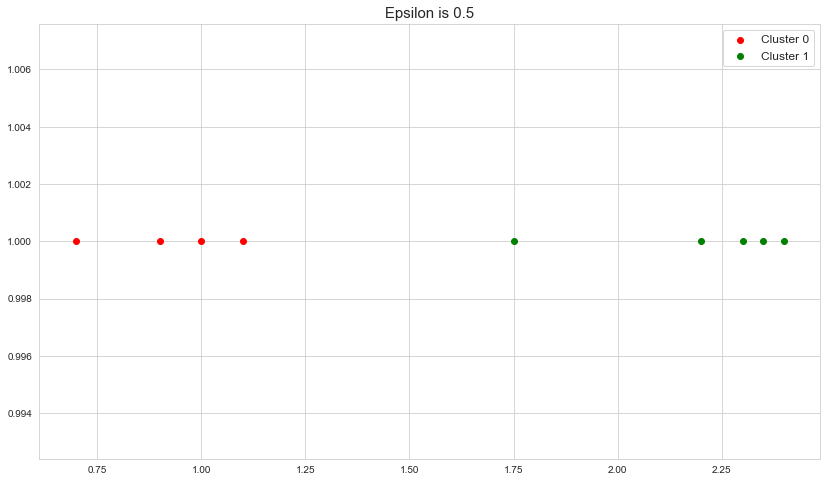

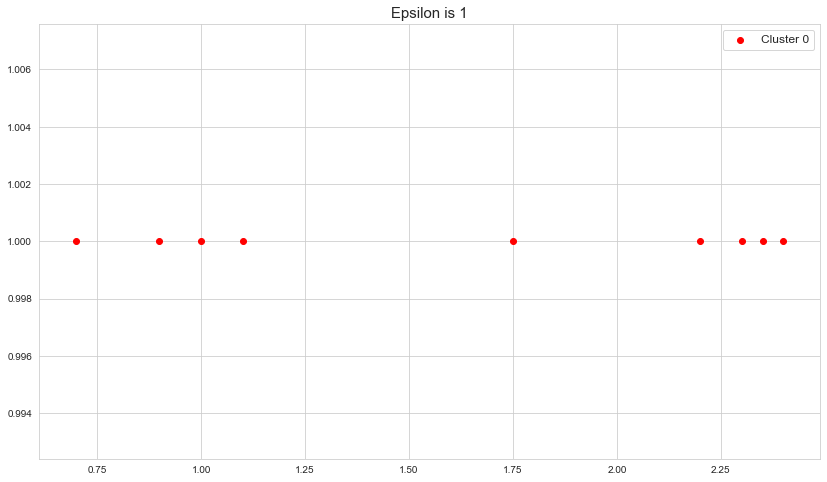

In [39]:
cs = ['r','g','b']

# Let's go through and. see what happens as we increase eps
for e in [.05,.1,.15,.2,.5,1]:
    plt.figure(figsize=(14,8))
    db = DBSCAN(min_samples = 2,eps=e)
    pred = db.fit_predict(np.array(x).reshape(-1,1))
    pred_set = list(set(pred))
    pred_set.sort()
    
    for i in range(len(pred_set)):
        plt.scatter(x[pred==pred_set[i]],
                    np.ones(len(x[pred==pred_set[i]])),
                    c=cs[i],label="Cluster " + str(pred_set[i]))
    
    plt.legend(fontsize=12)
    plt.title("Epsilon is " + str(e), fontsize=15)
    plt.show()
    
    
    

For additional understanding I found this quora thread quite helpful and it is actually where I got the terminology when explaining the algorithm <a href="https://www.quora.com/How-does-DBSCAN-algorithm-work">https://www.quora.com/How-does-DBSCAN-algorithm-work</a>.

I also suggest reading through the `DBSCAN` documentation, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html</a>.

## Questions?

<br>
<br>
<br>
<br>

## End Questions

## Practice

Return again to the synthetic data from the beginning of the notebook. Play around with the the `min_samples` and `eps` argument.  Should you implement any sort of scaling? These are things to consider when running through the algorithm.

In [81]:
np.random.seed(614)
X = np.concatenate([[-2,-2] + 1.7*np.random.randn(100,2),
                   [2,2] + 1.7*np.random.randn(100,2)])

In [ ]:
# Code Here
cs = ['r','g','b']

# Let's go through and. see what happens as we increase eps
for e in [.2,.5,1.,1.5]:
    plt.figure(figsize=(14,8))
    db = DBSCAN(min_samples = 5,eps=e)
    pred = db.fit_predict(X)
    pred_set = list(set(pred))
    pred_set.sort()
    
    for i in range(len(pred_set)):
        plt.scatter(X[pred==pred_set[i]],
                    np.ones(len(x[pred==pred_set[i]])),
                    c=cs[i],label="Cluster " + str(pred_set[i]))
    
    plt.legend(fontsize=12)
    plt.title("Epsilon is " + str(e), fontsize=15)
    plt.show()







In [98]:
# Code Here
db = DBSCAN(min_samples = 2,eps=.8)
pred = db.fit_predict(X)
df = pd.DataFrame(data=np.concatenate([X,pred.reshape(-1,1)], axis=1))



In [99]:
# Code Here

pred_set = list(set(pred))



,0,1,2
0,-1.377602,-0.156699,0.0
1,-3.219152,0.673856,1.0
2,-4.038816,-0.722514,2.0
3,0.762228,-1.482410,0.0
4,-2.046993,-0.753062,0.0
...,...,...,...
195,2.549524,1.641516,0.0
196,1.830841,4.515692,0.0
197,3.837763,1.778018,0.0
198,3.460791,3.807816,0.0


In [ ]:
# Code Here








## Practice More

How does DBSCAN perform on the MNIST dataset? How does the clustering compare to $k$ means and hierarchical clustering?

In [ ]:
# Code Here








In [ ]:
# Code Here








In [ ]:
# Code Here








In [ ]:
# Code Here








In [ ]:
# Code Here








In [ ]:
# Code Here








#### HDBSCAN 

The version of DBSCAN we just ran is closer to $k$ means than hierarchical clustering. An alternative approach is to use HDBSCAN which stands for, you guessed it, hierarchical DBSCAN.

This requires a different python package, `hdbscan`, <a href="https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html">https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html</a>.

That's it for this notebook. In Notebook 2 we stick with clustering but you'll be working through two problems on your own either in a breakout session or on your own time.

See ya there!